# How does pre-training affect the performance of a neural network? 
### 1. epochs
### 2. Batch size

In [ ]:
# Imported librarys
import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt

In [22]:
# Import helper functions from functions.py
import sys
import importlib
sys.path.append('..')
import functions
# reload file to check if there were any updates to file
importlib.reload(functions)
from functions import *

## Create neural network used in Q2

In [63]:
Path = "C:/Users/Billy/Documents/University/Year 4/Comp/CW2/palmerpenguins_extended.csv"
df_penguin_new = get_data(Path)
df_penguin = augment_data(df_penguin_new);
X_train, X_test, y_train, y_test = datasplit_train_test(df_penguin)

c:\Users\Billy\Documents\University\Year 4\Comp\CW2\CW2 Code\COURSEWORK-2-DATA-SCIENCE-PROJECT\py\Q3_folder\..\functions.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe_name.island = dataframe_name.island.replace({'Biscoe':0,'Dream':1,'Torgensen':2})
c:\Users\Billy\Documents\University\Year 4\Comp\CW2\CW2 Code\COURSEWORK-2-DATA-SCIENCE-PROJECT\py\Q3_folder\..\functions.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe_name.species = dataframe_name.species.replace({'Adelie':0,'Chinstrap':1,'Gentoo':2})
c

In [26]:
# Create a class for data as it is needed for pytoch data to train and test the neural network
class Mydata(torch.utils.data.Dataset):
    def __init__(self, X_train, y_train):
        super().__init__()
        # Add the features (X) and the target (y)
        self.X = torch.from_numpy(X_train.values).type(torch.FloatTensor)
        self.y = torch.from_numpy(y_train.values.flatten()).type(torch.LongTensor)
        self.len = self.X.shape[0]

    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [27]:
INPUT_NUM = 9
HIDDEN_NUM = 20
OUTPUT_NUM = 3

class MultiClassNet(nn.Module):
    def __init__(self, INPUT_NUM, HIDDEN_NUM, OUTPUT_NUM):
        super().__init__()
        self.lin1 = nn.Linear(INPUT_NUM, HIDDEN_NUM)
        self.lin2 = nn.Linear(HIDDEN_NUM, OUTPUT_NUM)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = self.lin2(x)
        x = self.log_softmax(x)
        return x

## Create functions to test impact of batch size and epoch number

In [ ]:
# Create a function containing code from Q2 that makes a model and trains it
# Function takes epoch number and train loader. 
# Can change epoch number test its impact on accuracy
# When making train loader you can change the batch size which allows you to measure its impact.

def nn_train(NUM_EPOCHS,train_loader):
    model = MultiClassNet(INPUT_NUM=INPUT_NUM, HIDDEN_NUM=HIDDEN_NUM, OUTPUT_NUM=OUTPUT_NUM)
    criterion = nn.CrossEntropyLoss()
    lr = 0.1
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(NUM_EPOCHS):
        
        for x, y in train_loader:

            # Initialize gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(x)

            # Calculate loss
            
            loss = criterion(y_pred, y)

            # Backpropagation
            loss.backward()

            # Update parameters
            optimizer.step()

    return model

In [ ]:
# Create function which will find accuracy of the model using the whole test dataset
# Function needs a test loader as changing this allows you to change batch size and measure its impact on the network

def Accuracy_whole(test_loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            features, labels = data
            # calculate outputs by running features through the network
            outputs = model(features)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    Accuracy = 100 * correct // total
    #print(f'Accuracy of the network on the test set: {100 * correct // total} %')
    return Accuracy

In [ ]:
# Create function which will find accuracy of the 3 classes in the palmer penguins dataset
# Function needs a test loader as changing this allows you to change batch size and measure its impact on the network

def Accuracy_class(test_loader):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    scores = []

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            features, labels = data
            outputs = model(features)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        #print(f'Accuracy for class: {classname:5f} is {accuracy:.1f} %')
        scores.append(accuracy)
    return scores

## Testing different number of epochs

In [ ]:
# Create list of the 3 classes in the dataset
classes = [0,1,2]

In [46]:
# To find how the number of epochs can affect the accuracy of a network train the model using a decreasing number of epochs

#record accuracy for each class and whole dataset for each epoch
epochAcc1 = []
epochAcc2 = []
epochAcc3= []
epochAccWhole = []

# Choose epoch numbers from 1 to 200: 1,25,50,67 .... 175,200
epochs = np.linspace(1,200,9,dtype=int).tolist()

# Create data set to be used keeping the batch size constant so it doesnt impact results
data_train_epoch = Mydata(X_train, y_train)
train_loader_epoch = torch.utils.data.DataLoader(dataset=data_train_epoch, batch_size=32)

# Iterate through each epoch number
for i in epochs:
    # train model using epoch i and same dataset each time
    model = nn_train(i,train_loader_epoch)
    PATH = './cifar_net.pth'
    torch.save(model.state_dict(), PATH)
    # Measure accurcay and add to lists to plot
    epochAccWhole.append(Accuracy_whole(train_loader_epoch))
    class1,class2,class3 = Accuracy_class(train_loader_epoch)
    epochAcc1.append(class1)
    epochAcc2.append(class2)
    epochAcc3.append(class3)

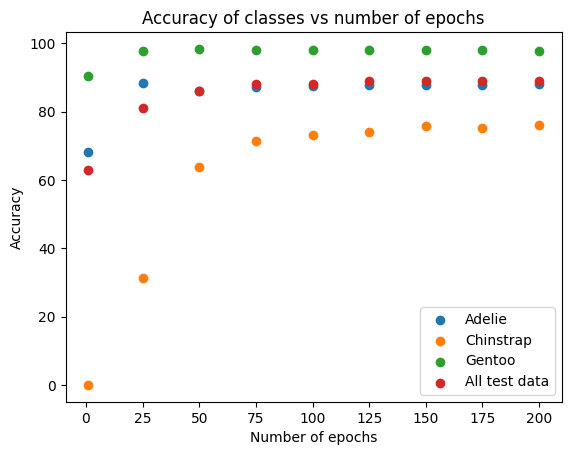

In [47]:
# Plot the accuracy recorded to see if there is any trends with changing the epoch number
plt.scatter(epochs,epochAcc1,label='Adelie')
plt.scatter(epochs,epochAcc2,label='Chinstrap')
plt.scatter(epochs,epochAcc3,label='Gentoo')
plt.scatter(epochs,epochAccWhole,label='All test data')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of classes vs number of epochs')
plt.legend()

In [61]:
# Print out start and end accuracy of each class
print("Adelie - Start:",epochAcc1[0],"End:",epochAcc1[-1])
print("Chinstrap - Start:",epochAcc2[0],"End:",epochAcc2[-1])
print("Gentoo - Start:",epochAcc3[0],"End:",epochAcc3[-1])

Adelie - Start: 68.19852941176471 End: 88.14338235294117
Chinstrap - Start: 0.0 End: 76.24434389140272
Gentoo - Start: 90.4707233065442 End: 97.81859931113662


From looking at the graph you can see that the Adelie and Gentoo classes have a small increase in accuracy at the start. <br> 
However for the Chinstrap class it has a large increase going from 0% to 76%. One reason for this may be due to the class distribution. <br> 

In [74]:
# Display number of entries for each species/class in the palmer penguins dataset
pd.DataFrame(df_penguin_new['species'].value_counts())

# You can see Chinstrap which was most effected by epoch number also has the smallest number of entries in the data

,count
species,
Adelie,1560
Gentoo,1247
Chinstrap,623


## Testing different batch sizes

In [ ]:
# First what epoch should be used to test batch size
# A lower epoch number will speed up how long it will take to get the results

#using the accuracy of the whole model we can choose a epoch number when the accuacy isnt benefiting from it increasing
print(epochs)
print(epochAccWhole)

# From these 125 is the number of epoch to use for the testing of batch size

[1, 25, 50, 75, 100, 125, 150, 175, 200]
[63, 81, 86, 88, 88, 89, 89, 89, 89]


In [68]:
# Create lists to record the accuracy of each class and whole dataset for each batch size
batchAcc1 = []
batchAcc2 = []
batchAcc3 = []
batchAccWhole = []

# Create a list of each batch size that is going to be tested
batches_num = np.linspace(16,320,19,dtype=int).tolist()

# Iterate over all batch sizes in list
for i in batches_num:
  # Create the training and test datasets using batch size i
  data_train_batch = Mydata(X_train, y_train)
  train_loader_batch = torch.utils.data.DataLoader(dataset=data_train_batch, batch_size=i)
  data_test_batch = Mydata(X_test,y_test)
  test_loader_batch = torch.utils.data.DataLoader(dataset=data_test_batch, batch_size=i)

  # Train neural network using new datasets
  # Keep epoch number constant so it doesnt effect results
  model = nn_train(125,train_loader_batch)
  PATH = './cifar_net.pth'
  torch.save(model.state_dict(), PATH)

  # Add accuracy for current batch size to lists for use later
  batchAccWhole.append(Accuracy_whole(test_loader_batch))
  class1,class2,class3 = Accuracy_class(test_loader_batch)
  batchAcc1.append(class1)
  batchAcc2.append(class2)
  batchAcc3.append(class3)

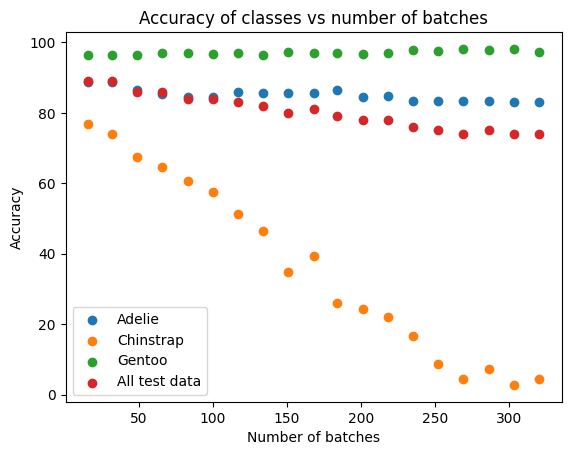

In [69]:
plt.scatter(batches_num,batchAcc1,label='Adelie')
plt.scatter(batches_num,batchAcc2,label='Chinstrap')
plt.scatter(batches_num,batchAcc3,label='Gentoo')
plt.scatter(batches_num,batchAccWhole,label='All test data')
plt.xlabel('Number of batches')
plt.ylabel('Accuracy')
plt.title('Accuracy of classes vs number of batches')
plt.legend()

In [70]:
# Print out start and end accuracy of each class
print("Adelie - Start:",batchAcc1[0],"End:",batchAcc1[-1])
print("Chinstrap - Start:",batchAcc2[0],"End:",batchAcc2[-1])
print("Gentoo - Start:",batchAcc3[0],"End:",batchAcc3[-1])

Adelie - Start: 88.77118644067797 End: 83.05084745762711
Chinstrap - Start: 76.79558011049724 End: 4.419889502762431
Gentoo - Start: 96.27659574468085 End: 97.34042553191489


The graph of batch size against Accuacy shows that for classes Adelie and Gentoo they remain unaffected by the batch size increasing. <br>
However similar to changing the number of epochs the the accuracy of prediction for the Chinstrap class greatly decreases as you increase the batch size.

In [73]:
# This again could be due to class distribution in the dataset being used
# leading the Chinstrap class with the lowest number of entries to be effected a lot more than the other classes.

# Display number of entries for each species/class in the palmer penguins dataset
pd.DataFrame(df_penguin_new['species'].value_counts())

,count
species,
Adelie,1560
Gentoo,1247
Chinstrap,623
